# Feature Visualization

## Copyright notice

This version (c) 2019 Fabian Offert, [MIT License](LICENSE). 

## Background

Feature visualization has been an important area of research within machine learning in general and deep learning in particular at least since 2014. "Deep Dream", for instance, works by applying feature visualization techniques to images, albeit optimized for producing the kind of visuals it has become famous for. Since then, particularly with the invention of GANs, more elaborate methods have emerged that employ natural image priors to "bias" visualizations towards more "legible" images. Recently, feature visualization and related methods have received a lot of attention as possible solutions to the problem of interpretability. Nevertheless, almost all visualization methods rely on the principle of activation maximization. They visualize the learned features of a particular neuron/channel/layer by optimizing an input image to maximally activate this neuron/channel/layer. Below, we visualize the features of selected channels from the InceptionV3 network, trained on ImageNet. For the classification layer, impressive visualizations like this are attainable with the default parameters.

![](img/banana.jpg)

## Imports

To be able to use mechanisms like differentiation and backpropagation we need a high-level library that abstracts these mathematical details away from us. We are using PyTorch, one of the de-facto standard frameworks for high-level prototyping for machine learning. We are also importing an existing, slightly modified network architecture: InceptionV3. Because we are operating in high-dimensional vector space, we are also using Numpy, the Python library for scientific computing. We are also importing various image filters from the skimage library. Finally, we are importing a bunch of helper functions to render images within the notebook environment.

In [1]:
import torch as t
import torch.nn as nn
import torchvision as tv

import numpy as np

import os
import random
from io import BytesIO
import PIL.Image
import IPython.display

from skimage.restoration import denoise_bilateral, denoise_tv_chambolle

from inception_debug import inception_v3

CUDA = False # Set this to True if using a GPU

## Settings

To visualize a network we need to know which layers are available. Here is an overview of the architecture of InceptionV3 (more information [here](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/) and in the [original paper](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.pdf)):
    
![](img/inception.jpg)

How do we know how these layers are called? We can simply load the model, add pre-trained ImageNet weights to it, and iterate over the available layers:

In [2]:
mode = None
if CUDA:
    model = inception_v3(pretrained=True).cuda()
else:
    model = inception_v3(pretrained=True)

model.eval() # Test mode, we are not training anything

print('Available modules:')
for n, name_module in enumerate(model.named_children()):
    print(n, name_module[0])
f = model # Alias

Available modules:
0 Conv2d_1a_3x3
1 Conv2d_2a_3x3
2 Conv2d_2b_3x3
3 Conv2d_3b_1x1
4 Conv2d_4a_3x3
5 Mixed_5b
6 Mixed_5c
7 Mixed_5d
8 Mixed_6a
9 Mixed_6b
10 Mixed_6c
11 Mixed_6d
12 Mixed_6e
13 AuxLogits
14 Mixed_7a
15 Mixed_7b
16 Mixed_7c
17 fc


## Image preprocessing and deprocessing

In [3]:
# Normalize each color sepearately (Photoshop auto tone)
def autotone_PIL(img):
    img = np.array(img)
    img[:,:,0] = np.interp(img[:,:,0], [np.amin(img[:,:,0]), np.amax(img[:,:,0])], [0, 255])
    img[:,:,1] = np.interp(img[:,:,1], [np.amin(img[:,:,1]), np.amax(img[:,:,1])], [0, 255])
    img[:,:,2] = np.interp(img[:,:,2], [np.amin(img[:,:,2]), np.amax(img[:,:,2])], [0, 255])
    img = PIL.Image.fromarray(img)
    return img

def deprocess(tensor):
    # Remove batch dimension
    # Shape before: BCSS (batch, channels, size, size)
    tensor = tensor.data.squeeze() 
    # Shape after: CSS
        
    # To CPU and numpy array
    img = tensor.cpu().numpy() 
    
    # Channels last
    # Shape before: CSS
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 0, 1)
    # Shape after: SSS

    # Clip to visible range
    img = np.clip(img, 0., 1.) # Clip to 0./1. range
    
    # 0./1. range to 0./255. range
    img *= 255. 
        
    # To PIL image format
    img = PIL.Image.fromarray(img.astype(np.uint8))  
    
    return img

def gray_square_PIL(size):
    # Gray square, -1./1. range
    img = np.random.normal(0, 0.01, (size, size, 3)) 
    
    # -1./1. range to 0./255. range
    img /= 2.
    img += 0.5
    img *= 255.

    # To PIL image format
    img = PIL.Image.fromarray(img.astype(np.uint8))
    
    return img
    
def show_img_PIL(img, fmt='jpeg'):
    f = BytesIO()
    img.save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    
def pytorch_to_skimage(img):
    # No batch dimension
    img = img[0]
    # Channels last
    img = np.swapaxes(img, 0, 2)
    return img
    
def skimage_to_pytorch(img):
    # Channels first
    img = np.swapaxes(img, 0, 2)
    # Skimage uses double
    img = img.astype(np.float32)
    # No Batch dimension
    img = np.expand_dims(img, 0)
    return img

## Hyperparameters

In [9]:
ITERATIONS = 30 # Default 300, very good: 2000
FILTER = 20 # TV filter frequency, default 20
JITTER = 32 # Jitter max. offset, default 32
LR = 0.4 # Learning rate, default 0.4
L2 = 1e-4 # L2 regularization, default 1e-4
OCTAVES = 3 # Octaves, default 3
SCALE = 1.5 # Octave scale, default 1.5
ORIGINAL_SIZE = 299 # Inception V3, do not change

## Gradient ascent function

The optimization tricks are compiled from various papers. This is an experimentally verified optimal combination.

In [5]:
def gradient_ascent(img, layer, neuron, shape, predictions):
            
    # Pytorch is channels first, this happens here!
    preprocess = tv.transforms.Compose([tv.transforms.Resize(shape), tv.transforms.ToTensor()])
    
    # unsqueeze(0) adds batch dimension
    # cuda() puts on GPU
    # requires_grad_() switches on gradients (gradients for the model are switched off in model.eval())
    input = None
    if CUDA:
        input = preprocess(img).unsqueeze(0).cuda().requires_grad_()
    else:
        input = preprocess(img).unsqueeze(0).requires_grad_()
    
    # Define the stochastic gradient descent optimizer
    optimizer = t.optim.SGD([input], lr=LR, weight_decay=L2)
    
    # Optimize
    for i in range(ITERATIONS):
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Jitter on
        if JITTER:
            npimg = input.data.cpu().numpy() # To CPU and numpy
            ox, oy = np.random.randint(-JITTER, JITTER+1, 2)
            npimg = np.roll(np.roll(npimg, ox, -1), oy, -2) # Jitter
            if CUDA:
                input.data = t.from_numpy(npimg).cuda()
            else:
                input.data = t.from_numpy(npimg)
        
        # Custom forward() function in inception_debug.py to keep all the extra stuff from the default
        # forward() function while going through the model layer by layer
        x = f.forward_layer(input, layer) # Forward pass up to the feature extractor layer
        
        # Prediction layer
        if predictions:
            loss = -x[:,neuron]
        
        # Other layer
        # See https://pytorch.org/docs/stable/torch.html#torch.norm,
        # equivalent to Keras K.maximum(K.mean(K.abs(x)), K.epsilon())
        else:
            loss = -x[:,neuron].norm()

        loss.backward()
        optimizer.step()
        
        # Jitter off
        if JITTER:
            npimg = input.data.cpu().numpy() # To CPU and numpy
            npimg = np.roll(np.roll(npimg, -ox, -1), -oy, -2) # Jitter
            if CUDA:
                input.data = t.from_numpy(npimg).cuda()
            else:
                input.data = t.from_numpy(npimg)
            
        # Stochastic clipping
        input.data[input.data > 1] = np.random.uniform(0, 1)
        input.data[input.data < 0] = np.random.uniform(0, 1)
        
        # TV filtering
        if i != ITERATIONS - 1: # No regularization on last iteration for good quality output
            if i % FILTER == 0:
                npimg = input.data.cpu().numpy() # To CPU and numpy
                npimg = pytorch_to_skimage(npimg)
                npimg = denoise_tv_chambolle(npimg, weight=0.1, multichannel=True)
                npimg = skimage_to_pytorch(npimg)
                if CUDA:
                    input.data = t.from_numpy(npimg).cuda()
                else:
                    input.data = t.from_numpy(npimg)

    img = deprocess(input)
    return img

## Generate function

In [6]:
def generate(layer, neuron, predictions):
    
    # Prepare octaves, they are the same for all neurons/layers
    original_shape = (ORIGINAL_SIZE, ORIGINAL_SIZE)
    successive_shapes = [original_shape]
    for i in range(1, OCTAVES):
        hw = int(successive_shapes[i-1][0] * SCALE)
        successive_shapes.append((hw, hw))
    final_shape =  successive_shapes[-1]

    # Input noise image
    img = gray_square_PIL(ORIGINAL_SIZE)
    
    # Excplicitly copy noise image
    final_img = img.copy()

    # Do octaves
    shrunk_final_img = img.resize(successive_shapes[0], PIL.Image.ANTIALIAS)
    for octave, shape in enumerate(successive_shapes):
        
        print('layer', layer, 'neuron', neuron, 'octave', octave+1, '/', OCTAVES, 'shape', shape)

        img = gradient_ascent(img, layer, neuron, shape, predictions)

        # Resize ("upscale") previous shape original image to current shape
        upscaled_shrunk_final_img = shrunk_final_img.resize(shape, PIL.Image.ANTIALIAS)

        # Resize ("downscale") original shape original image to current shape
        same_size_final_img = final_img.resize(shape, PIL.Image.ANTIALIAS)

        # Find the details that are lost in the upscaling process (in numpy space)
        lost_detail = np.array(same_size_final_img) - np.array(upscaled_shrunk_final_img)

        # Add these details back to the optimized image (in numpy space)
        img = np.array(img) + lost_detail

        # To PIL
        img = PIL.Image.fromarray(img)

        # Prepare for next ocatve
        shrunk_final_img = final_img.resize(shape, PIL.Image.ANTIALIAS)

        # Show with autotone
        show_img_PIL(autotone_PIL(img))
        
    img = autotone_PIL(img)      
    return img

## Load class definitions

In [7]:
with open('synset_words.txt') as synset_words_file:
    synset_words = synset_words_file.readlines()

for i, line in enumerate(synset_words):
    synset_words[i] = line.replace(' ', '_').replace(',', '_').lower().strip()

## Run everything

987 corn
layer 5 neuron 100 octave 1 / 3 shape (299, 299)


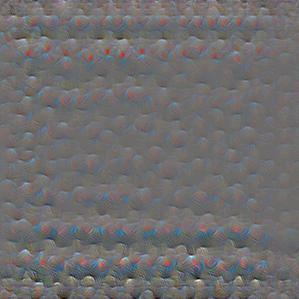

layer 5 neuron 100 octave 2 / 3 shape (448, 448)


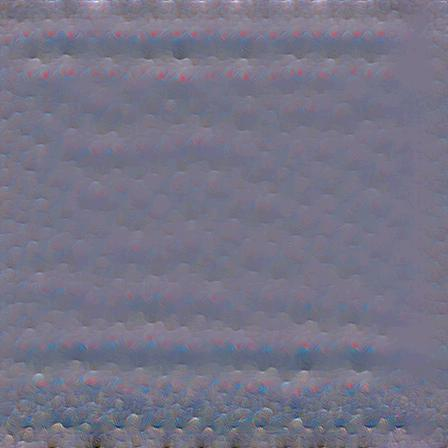

layer 5 neuron 100 octave 3 / 3 shape (672, 672)


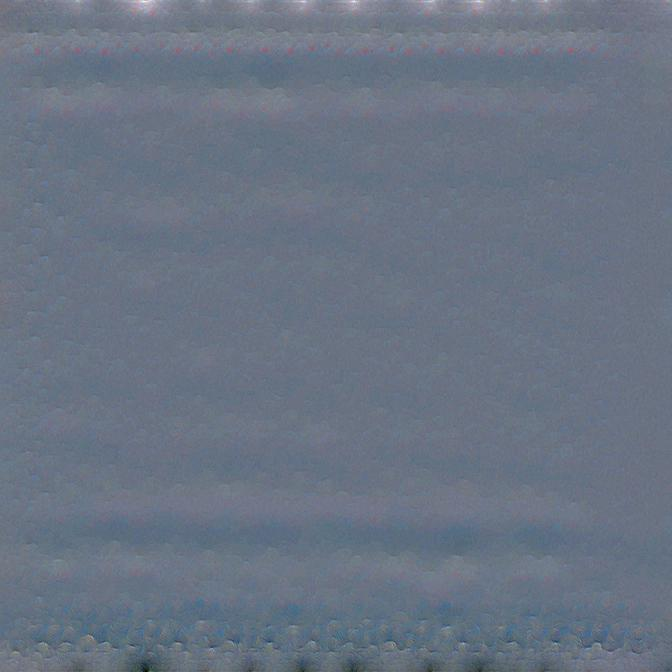

In [15]:
class_ = 987
print(class_, synset_words[class_])
img = generate(5, 100, predictions=False)